**Basiert auf Colab https://colab.research.google.com/github/iampatgrady/Simple-Probabalistic-Model-For-Google-Analytics-Users/blob/master/Multitouch_Attribution_Modeling.ipynb**

In [ ]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pylab as plt
plt.style.use("fivethirtyeight")

In [ ]:
from google.colab import auth
auth.authenticate_user()

project="attribution-303016"
sql_query="SELECT * FROM `attribution-303016.Test2.testga` ORDER BY fullVisitorId ASC"

ga_data = pd.io.gbq.read_gbq(sql_query,project_id=project,dialect='standard')

print (ga_data.shape)
ga_data.sample(5)

(714167, 3)


fullVisitorId            channels  converted
63595   0892642292027514252          [Referral]          0
109166  1535020772434020368            [Social]          0
637053  8918422916976278171            [Social]          0
310085  4349016365117405804            [Social]          0
387410  5430879576678891336  [Direct, Referral]          1

In [ ]:
channel_metrics_map = {}  

for user in ga_data.to_records(): 
    
    for channel in user["channels"]:
        
        if not channel in channel_metrics_map:
            channel_metrics_map[channel] = { "conversions": 0.0, "users": 0.0 }
            
        channel_metrics_map[channel]["conversions"] += float(user["converted"])
        channel_metrics_map[channel]["users"] += 1.0 

pd.DataFrame(channel_metrics_map).transpose().sort_values(by='conversions',ascending=False)

conversions     users
Referral             4685.0   65507.0
Organic Search       3496.0  311429.0
Direct               2223.0  109795.0
Paid Search           554.0   18600.0
Display               201.0    4027.0
Social                118.0  212352.0
Affiliates             14.0   13399.0
(Other)                 1.0      86.0

In [ ]:
channel_metrics = channel_metrics_map.copy()

for xi,xj in itertools.combinations(channel_metrics.keys(), 2):
    
    key = "{}|{}".format(xi, xj)
    
    for user in ga_data.loc[ga_data.channels.map(lambda c: ((xi in c) & (xj in c))) == True].to_records():
         
        if not key in channel_metrics: 
            channel_metrics[key] = { "conversions": 0.0, "users": 0.0 }

        channel_metrics[key]["conversions"] += float(user[3]) 
        channel_metrics[key]["users"] += 1.0 

pd.DataFrame(channel_metrics).transpose().sort_values(by='conversions', ascending=False) \
    .reset_index().rename(columns={'index':'channels'})[:10]

channels  conversions     users
0                    Referral       4685.0   65507.0
1              Organic Search       3496.0  311429.0
2                      Direct       2223.0  109795.0
3                 Paid Search        554.0   18600.0
4             Direct|Referral        393.0    3141.0
5     Organic Search|Referral        380.0    4738.0
6                     Display        201.0    4027.0
7  Organic Search|Paid Search        169.0    3688.0
8       Organic Search|Direct        129.0    2988.0
9                      Social        118.0  212352.0

In [ ]:
for key in channel_metrics:
    channel_metrics[key]["conversion rate"] = np.divide(
        channel_metrics[key]["conversions"] , 
        channel_metrics[key]["users"]
    )

pd.DataFrame(channel_metrics).transpose().sort_values(by='conversions', ascending=False) \
    .reset_index().rename(columns={'index':'channels'})[:5]

channels  conversions     users  conversion rate
0         Referral       4685.0   65507.0         0.071519
1   Organic Search       3496.0  311429.0         0.011226
2           Direct       2223.0  109795.0         0.020247
3      Paid Search        554.0   18600.0         0.029785
4  Direct|Referral        393.0    3141.0         0.125119

In [ ]:
channels = [ c for c in channel_metrics.keys() if not "|" in c ]
channel_contrib = {} 

for channel in channels:
    
    p_xi = channel_metrics[channel]["conversion rate"]
    
    combinations = [ c for c in channel_metrics.keys() if channel in c and "|" in c ] 
    n = np.divide(1.0 , float(2 * len(combinations)))
    
    sum_part = []
    
    for combination in combinations:
        
        xi_xj = channel_metrics[combination]["conversion rate"]
                                             
        xi = channel_metrics[ combination.split("|")[0] ]["conversion rate"]
        xj = channel_metrics[ combination.split("|")[1] ]["conversion rate"]
                                             
        sum_part.append(xi_xj - xi - xj)
    
    s = np.sum(sum_part)
    channel_contrib[channel] = p_xi + n * (s if s > 0 else 0)

pd.DataFrame([channel_contrib]).transpose()

0
Organic Search  0.011226
Social          0.000556
Paid Search     0.029785
Affiliates      0.001045
Direct          0.020247
Referral        0.071519
Display         0.049913
(Other)         0.011628

In [ ]:
c_sum = np.sum([ channel_contrib[ch] for ch in channel_contrib.keys() ])
for key in channel_contrib.keys():
    channel_contrib[key] /= c_sum
    
results = pd.DataFrame(channel_contrib.items())
results.columns=['channel','contribution']
print (format(sum(results["contribution"])))
results.sort_values(by='contribution',ascending=False).reset_index(drop=True)

0.9999999999999999


channel  contribution
0        Referral      0.365046
1         Display      0.254765
2     Paid Search      0.152028
3          Direct      0.103343
4         (Other)      0.059351
5  Organic Search      0.057298
6      Affiliates      0.005333
7          Social      0.002836

In [ ]:
results["conversions"] = results.channel.map(lambda x: channel_metrics[x]["conversions"])

results["score"] = results["conversions"] * results["contribution"]

results['importance'] = np.divide(
    results['score']-results['score'].min() , 
    results['score'].max()-results['score'].min()
)

results = results.sort_values('importance',ascending=False).fillna(0).reset_index(drop=True)
results

channel  contribution  conversions        score  importance
0        Referral      0.365046       4685.0  1710.239922    1.000000
1          Direct      0.103343       2223.0   229.732227    0.134297
2  Organic Search      0.057298       3496.0   200.313102    0.117095
3     Paid Search      0.152028        554.0    84.223279    0.049213
4         Display      0.254765        201.0    51.207791    0.029908
5          Social      0.002836        118.0     0.334683    0.000161
6      Affiliates      0.005333         14.0     0.074664    0.000009
7         (Other)      0.059351          1.0     0.059351    0.000000

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

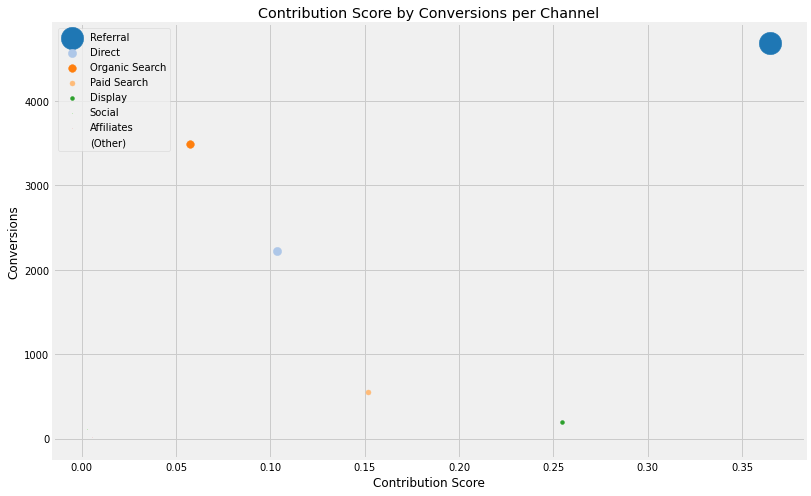

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))
cmap = plt.cm.get_cmap('tab20')
for i,row in results.iterrows():
  ax.scatter("contribution", "conversions",label=row.channel,
             s=row.importance*500, c=cmap(i), data=row)
plt.xlabel("Contribution Score")
plt.ylabel("Conversions")
plt.title("Contribution Score by Conversions per Channel")
plt.legend(loc=0)
plt.show()